In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 87.8 MB/s eta 0:00:00:00:0100:01


In [3]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rasterio
from skimage.measure import label, regionprops
import sys

sys.path.insert(0, "/kaggle/input/model-used")
WEIGHTS_PATH = "/kaggle/input/model-weigths/best_swin_v2.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REFLECT_SCALE = 1e4
IMG_SIZE = (H_in, W_in) = (224, 224)  #

from swin_unet_v2 import SwinTransformerSys
model = SwinTransformerSys(
    img_size=IMG_SIZE[0], patch_size=4, in_chans=23, num_classes=23,
    embed_dim=96, depths=[2,2,2,2], depths_decoder=[1,2,2,2],
    num_heads=[3,6,12,24], window_size=7, mlp_ratio=4.0,
    drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.1,
    norm_layer=torch.nn.LayerNorm, final_upsample="expand_first"
).to(device)
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
model.eval()
print("Model ready on device:", device)

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:23
---final upsample expand_first---


/tmp/ipykernel_31/708081706.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))


Model ready on device: cuda


## Inference 

In [4]:
def infer_path(path, threshold=0.5, bands_1b=list(range(1,24))):
    if path.lower().endswith('.npy'):
        arr = np.load(path)  # (23,H0,W0)
    else:
        with rasterio.open(path) as src:
            arr = src.read(bands_1b)
    _, H0, W0 = arr.shape
    # Day t false-color RGB
    rgb_t = np.clip(np.moveaxis(arr[[3,2,1]]/REFLECT_SCALE,0,-1),0,1)
    x0 = torch.from_numpy(np.nan_to_num(arr)/REFLECT_SCALE).unsqueeze(0).float().to(device)
    x_resized = F.interpolate(x0, size=IMG_SIZE, mode='bilinear', align_corners=False)
    with torch.no_grad():
        out = model(x_resized)                    # (1,23,h,w)
        fire_logit = out[:,0:1]                   # (1,1,h,w)
        fire_prob_res = torch.sigmoid(fire_logit)[0,0]  # (h,w)
        pred_reflect = out[0].cpu().numpy()*REFLECT_SCALE  # (23,h,w)
    #Upsample to original resolution
    fire_prob = F.interpolate(
        fire_prob_res.unsqueeze(0).unsqueeze(0), size=(H0,W0),
        mode='bilinear', align_corners=False
    ).squeeze().cpu().numpy()
    pred_reflect_up = F.interpolate(
        torch.from_numpy(pred_reflect).unsqueeze(0), size=(H0,W0),
        mode='bilinear', align_corners=False
    )[0].numpy()
    rgb_pred = np.clip(np.moveaxis(pred_reflect_up[[3,2,1]]/REFLECT_SCALE,0,-1),0,1)
    mask = (fire_prob>threshold).astype(np.uint8)
    return arr, fire_prob, mask, rgb_t, rgb_pred

In [5]:
sample_t  = "/kaggle/input/wildfirespreadts/preprocessed_images/preprocessed_images/2018/fire_21458806/2018-01-25.npy"
best_thr  = 0.55
arr0, fire_prob, mask_pred, rgb_t, rgb_pred = infer_path(sample_t, threshold=best_thr)
sample_t1 = sample_t.replace("2018-01-25.npy","2018-01-26.npy")
arr1      = np.load(sample_t1)
mask_t    = (arr0[0]/REFLECT_SCALE>0).astype(np.uint8)
mask_t1   = (arr1[0]/REFLECT_SCALE>0).astype(np.uint8)
growth    = (mask_t1==1)&(mask_t==0)

## Burned area prediction

Predicted fire pixels: 29917, Area: 26.93 km²


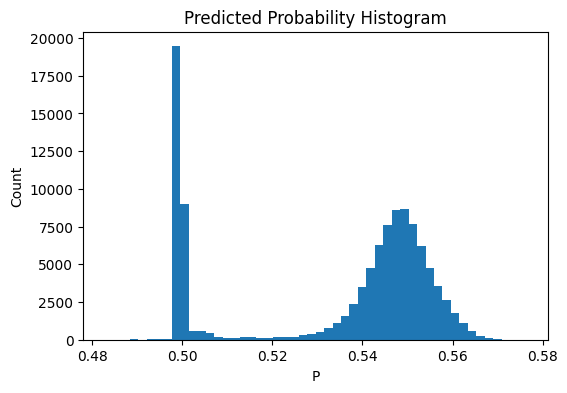

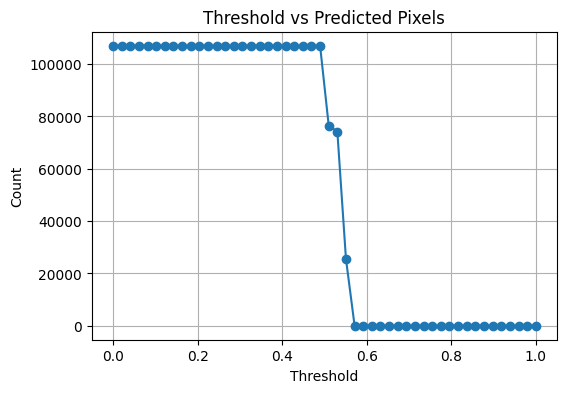

In [6]:
pixel_area_km2 = (30*30)/1e6
n_pred = mask_pred.sum()
area_pred = n_pred * pixel_area_km2
print(f"Predicted fire pixels: {n_pred}, Area: {area_pred:.2f} km²")
plt.figure(figsize=(6,4)); plt.hist(fire_prob.flatten(), bins=50)
plt.title('Predicted Probability Histogram'); plt.xlabel('P'); plt.ylabel('Count'); plt.show()

ths = np.linspace(0,1,50)
counts = [(fire_prob>t).sum() for t in ths]
plt.figure(figsize=(6,4)); plt.plot(ths,counts,marker='o')
plt.title('Threshold vs Predicted Pixels'); plt.xlabel('Threshold'); plt.ylabel('Count'); plt.grid(True); plt.show()


## Hotspots detection

In [7]:
N=5
flat_idx = np.argpartition(-fire_prob.flatten(), N)[:N]
ys, xs = np.unravel_index(flat_idx, fire_prob.shape)
hotspots = [{'x':int(x),'y':int(y),'p':float(fire_prob[y,x])} for x,y in zip(xs,ys)]
print('Top hotspots:', hotspots)


Top hotspots: [{'x': 125, 'y': 294, 'p': 0.5745258927345276}, {'x': 125, 'y': 295, 'p': 0.5746221542358398}, {'x': 129, 'y': 313, 'p': 0.5765360593795776}, {'x': 128, 'y': 313, 'p': 0.5758327841758728}, {'x': 125, 'y': 296, 'p': 0.5739333629608154}]


## Growth direction and Burn corridors

Propagation toward: SW


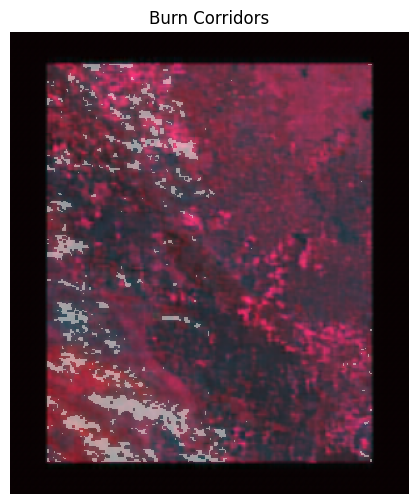

In [8]:
sample_t1 = sample_t.replace("2018-01-25.npy","2018-01-26.npy")  # adjust to actual next-day path
arr1 = np.load(sample_t1)
mask_t = (arr0[0]/REFLECT_SCALE>0).astype(np.uint8)
mask_t1 = (arr1[0]/REFLECT_SCALE>0).astype(np.uint8)

growth = (mask_t1==1)&(mask_t==0)
def get_centroid(m): props=regionprops(label(m)); return None if not props else np.array(props[0].centroid)[::-1]
ct = get_centroid(mask_t); cg = get_centroid(growth)
if ct is not None and cg is not None:
    dx,dy = cg-ct; direction=('S' if dy>0 else 'N')+('E' if dx>0 else 'W')
    print('Propagation toward:',direction)
else:
    print('Centroid not found for growth or base mask.')

# Burn corridors overlay
corr_threshold = ((rgb_t.mean(axis=2)-rgb_pred.mean(axis=2)).mean()+(rgb_t.mean(axis=2)-rgb_pred.mean(axis=2)).std())
corr_mask = (rgb_t.mean(axis=2)-rgb_pred.mean(axis=2))>corr_threshold
plt.figure(figsize=(6,6)); plt.imshow(rgb_pred); plt.imshow(np.ma.masked_where(~corr_mask,corr_mask), cmap='Reds',alpha=0.5)
plt.title('Burn Corridors'); plt.axis('off'); plt.show()


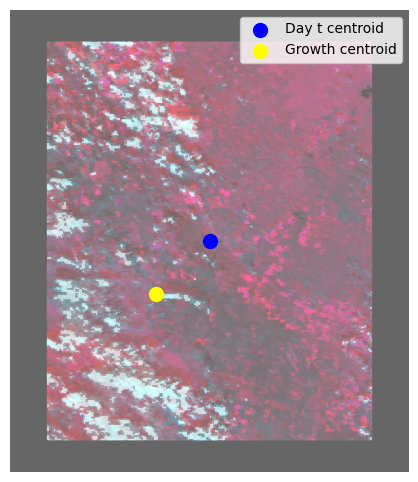

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(rgb_t, alpha=0.6)
plt.imshow(np.ma.masked_where(~corr_mask, corr_mask), cmap='Greys', alpha=0.5)

plt.scatter(ct[0], ct[1], c='blue', s=100, label='Day t centroid')
plt.scatter(cg[0], cg[1], c='yellow', s=100, label='Growth centroid')

plt.legend(loc='upper right')
plt.axis('off')
plt.show()


## Ground truth fire area & newly burned area

In [10]:
# areas for Day t and Day t+1 true masks
n_t_true = mask_t.sum()
n_t1_true = mask_t1.sum()
area_t_true = n_t_true * pixel_area_km2
area_t1_true = n_t1_true * pixel_area_km2
delta_area = area_t1_true - area_t_true
print(f"Day t true fire area : {area_t_true:.2f} km² ({n_t_true} pixels)")
print(f"Day t+1 true fire area : {area_t1_true:.2f} km² ({n_t1_true} pixels)")
print(f"Newly burned (Δ area) : {delta_area:.2f} km² ({n_t1_true-n_t_true} pixels)")


Day t true fire area : 67.85 km² (75384 pixels)
Day t+1 true fire area : 67.85 km² (75390 pixels)
Newly burned (Δ area) : 0.01 km² (6 pixels)


In [11]:
mask_t  = (arr0[0] / REFLECT_SCALE > 0).astype(np.uint8)
mask_t1 = (arr1[0] / REFLECT_SCALE > 0).astype(np.uint8)
print("Pixels Day t :", mask_t.sum())
print("Pixels Day t+1:", mask_t1.sum())


Pixels Day t : 75384
Pixels Day t+1: 75390


True new‐fire pixels : 8 (0.007 km²)
Pred new‐fire pixels : 5 (0.004 km²)
False positives : 0 pixels
False negatives : 3 pixels
Growth‐IoU : 0.625


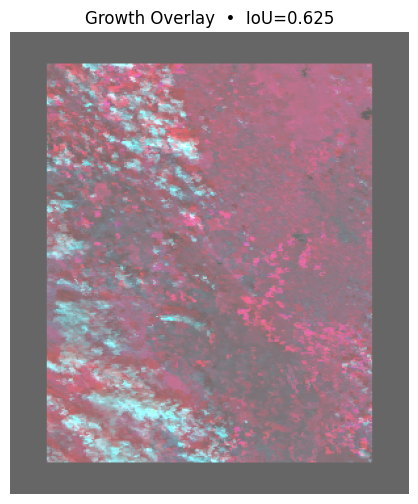

In [13]:
from skimage.morphology import remove_small_objects
from sklearn.metrics       import jaccard_score
import matplotlib.pyplot    as plt
import numpy                as np

# model’s predicted mask for the identified sample
best_thr  = 0.55
fire_prob, _, mask_pred, rgb_t, _ = infer_path(sample_t, threshold=best_thr)

# raw growth masks
mask_t       = (arr0[0] / REFLECT_SCALE > 0)         # Day t true fire
true_growth  = growth                              
raw_pred     = (mask_pred == 1) & (~mask_t)          # raw predicted growth

pred_growth  = remove_small_objects(raw_pred, min_size=5)

# Counts & areas
n_true    = true_growth.sum()
n_pred    = pred_growth.sum()
area_true = n_true * pixel_area_km2
area_pred = n_pred * pixel_area_km2

print(f"True new‐fire pixels : {n_true} ({area_true:.3f} km²)")
print(f"Pred new‐fire pixels : {n_pred} ({area_pred:.3f} km²)")

# false positives / false negatives
fp = np.logical_and(pred_growth, ~true_growth).sum()
fn = np.logical_and(~pred_growth, true_growth).sum()
print(f"False positives : {fp} pixels")
print(f"False negatives : {fn} pixels")

# Growth‐region IoU
tg = true_growth.astype(int).flatten()
pg = pred_growth.astype(int).flatten()
iou_growth = jaccard_score(tg, pg)
print(f"Growth‐IoU : {iou_growth:.3f}")

plt.figure(figsize=(6,6))
plt.imshow(rgb_t, alpha=0.6)
plt.imshow(np.ma.masked_where(~true_growth,  true_growth),  cmap='Reds',  alpha=0.5, label='True growth')
plt.imshow(np.ma.masked_where(~pred_growth, pred_growth), cmap='Blues', alpha=0.5, label='Pred growth')
plt.title(f"Growth Overlay  •  IoU={iou_growth:.3f}")
plt.axis('off')
plt.show()
